# Note on Gridworld Action Space Restriction
There is a problem, potentially, since staying in a location is not an allowable action (technically) but an agent could repeatedly choose an invalid action (if the invalid action is selectable in the first place). So I need to further prune the set of actions, depending on the state, but I do not want to do so in a way that is manual.

The way to do this is to count the number of non-corner edge states and account for that in the allowable set of actions. Since the area of the grid is length^2, the perimeter is 4$*$length, and the number of non-corner edge states is therefore 4$*$(length-1) and the number of corners is 4. Therefore, the number of allowable actions (dependent on state) is: $\left(4*{length}^2-4*length\right)*4+4*(length-1)*3+4*2$ so for $length=5$ we have $(100-20)*4+16*3+8=320+48+8=376$ actions.

## SARSA Implementation
To enable graphical output, have the render_init variable = 't' on line 14

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pylab
import gym
import sys
from gym import error, spaces, utils
from gym.utils import seeding
import matplotlib.ticker as plticker

class gridworld(gym.Env):
  metadata = {'render.modes': ['human']}

  def __init__(self): 
    self.render_label = 'f'
    self.gridnum = int(7) #size of gridworld
    self.location_x = np.random.randint(int(1),self.gridnum-1)
    self.location_y = np.random.randint(int(1),self.gridnum-1)
    self.action = int(0) # no initial action until computed
    self.previous_action = self.action
    self.previous_x = self.location_x
    self.previous_y = self.location_y
    self.previous_previous_x = self.previous_x
    self.previous_previous_y = self.previous_y
    self.allowed_actions = np.array([1,2,3,4])[np.newaxis]
    self.actionSet = np.matrix([1,2,3,4])
    self.episode_length = int(100)
    self.num_episodes = int(10000) # currently only running one episode, 10000
    self.my_alpha = 0.1
    self.my_gamma = 0.9
    self.my_epsilon = 0.1
    self.my_reward =np.array([ [-1,-1,-1,-1,-1,-1,-1],[-1, 0, 10, 0, 5, 0, -1],[-1, 0, 0, 0, 0, 0, -1],\
    [-1, 0, 0, 0, 0, 0, -1],[-1, 0, 0, 0, 0, 0, -1],[-1, 0, 0, 0, 0, 0, -1],[-1, -1, -1, -1, -1, -1, -1] ]) 
    self.my_reward = np.flipud(self.my_reward)
    self.my_reward_model = np.zeros([self.gridnum,self.gridnum])#reward model updated based on observations
    self.my_q_function = np.random.rand(self.gridnum,self.gridnum, int(4))# randomly initialized via reward model
    self.my_q_function[0::6,:,:] = 0# to prevent biasing agent with favorable "out of bound" q functions
    self.my_q_function[:,0::6,:] = 0# to prevent biasing agent with favorable "out of bound" q functions
    self.my_reward_log = np.random.rand(1, self.episode_length*self.num_episodes) # used to store reward for each time step
    self.my_episodic_cumulative_reward_log = np.random.rand(1,self.num_episodes)
    self.update_q_label = 0
    self.color_array = ['blue','orange']
    self.episode_counter = 0
    self.my_exploit_action_log = np.random.rand(self.gridnum,self.gridnum)
    self.my_state_log = np.random.rand(2, self.episode_length*self.num_episodes)
    pass
  def my_policy(self,time_index):
    if self.update_q_label > 1:
        self.previous_action = self.action # still want this because the agent selected a poor action and should evaluate it
    self.action = self.allowed_actions[0,\
    np.argmax(self.my_q_function[self.location_x,self.location_y,self.allowed_actions-1])]
    self.my_exploit_action_log[self.location_y,self.location_x] = int(self.action)
    if np.random.rand() <= self.my_epsilon:
        self.action = self.allowed_actions[0,np.random.randint(0,self.allowed_actions.shape[1])]
    pass
  def render(self,fig,ax,time_index): #mode='human', close=False <- no idea what this is for
    ax = fig.gca()    
    ax.clear()
    ax.grid(which='major', axis='both', linestyle='-')
    circle2 = plt.Circle((world.location_x+0.5, world.location_y+0.5), 0.5, color=self.color_array[np.mod(self.episode_counter,2)])#rand initialization
    ax.add_artist(circle2)
    fig.canvas.draw()
    pass
  def render_init(self):
    fig, (ax)=plt.subplots()
    intervals = float(1/world.gridnum)# dimension of grid affects size
    loc = plticker.MultipleLocator(base=intervals)
    ax.xaxis.set_major_locator(loc)
    ax.set_xlim(0, world.gridnum)
    ax.yaxis.set_major_locator(loc)
    ax.set_ylim(0, world.gridnum)
    return fig, ax
  def reset(self):
    self.location_x = np.random.randint(int(1),self.gridnum-1)
    self.location_y = np.random.randint(int(1),self.gridnum-1)
    self.previous_x = self.location_x
    self.previous_y = self.location_y
    self.previous_previous_x = self.previous_x
    self.previous_previous_y = self.previous_y
    self.update_q_label = 0
    self.episode_counter += 1
    pass
  def step(self):
    self.previous_previous_x = self.previous_x
    self.previous_previous_y = self.previous_y
    self.previous_x = self.location_x# only accurate for second step in episode
    self.previous_y = self.location_y# only accurate for second step in episode
    desired_action = self.action
    if np.random.rand() <= 0.1: # this part of the method is to enforce a 10% chance of a random transition
        self.action = self.allowed_actions[0,np.random.randint(1,self.allowed_actions.shape[1])]
    if self.my_reward[self.location_y,self.location_x] > 0:
        self.location_x = 3+1
        self.location_y = 2+1
        if self.my_reward[self.previous_y,self.previous_x] > 5:
            self.location_x = 1+1
            self.location_y = 0+1
    elif self.action == 1: # this part of the method is to select the desired deterministic action
        self.location_y += 1
    elif self.action == 2:
        self.location_y += -1
    elif self.action == 3:
        self.location_x += -1
    elif self.action == 4:
        self.location_x += 1
    self.action = desired_action# reports selected action, but has the agent move according to transition probability
    pass #return [(self.location_x, self.location_y)]
  def update_reward_model(self):# reversed y and x for reward (not model) to accommodate human-readable reward
    self.my_reward_model[self.location_y,self.location_x] = self.my_reward[self.location_y,self.location_x]
    pass
  def update_my_q_function(self):#,action,location_x,location_y):
    if self.update_q_label > 1:# update_q_label ensures that we do not update the q function when location is reset
        self.my_q_function[self.previous_previous_x,self.previous_previous_y,self.previous_action-1] +=\
        self.my_alpha*(self.my_reward_model[self.previous_previous_y,self.previous_previous_x]+\
        self.my_gamma*self.my_q_function[self.previous_x,self.previous_y,self.action-1]-\
        self.my_q_function[self.previous_previous_x,self.previous_previous_y,self.previous_action-1])
    pass
world = gridworld()
if world.render_label == 't':
    fig, (ax) = world.render_init()
k=0 # counter for episodic cumulative reward
for i in range(1,world.episode_length * world.num_episodes - 1):
    world.update_reward_model()
    world.my_reward_log[0,i] = world.my_reward[world.location_y,world.location_x]
    world.my_state_log[:,i] = np.array([world.location_x,world.location_y])[np.newaxis]
    world.update_my_q_function()#update is for previous state, so put before state reversion
    world.update_q_label += 1# default is to update the q function after the first iteration
    if world.my_reward[world.location_y,world.location_x] < 0:
        world.location_x = world.previous_x
        world.location_y = world.previous_y
    world.my_policy(i) # closest to pragmatic results here
    world.step()# current state is now state AFTER action has been taken
    if np.mod(i+1,world.episode_length) == 0:
        world.my_episodic_cumulative_reward_log[0,k] = \
        np.sum(world.my_reward_log[0,(k*world.episode_length):(i+1)])# sums from k*episode_length to i
        k += 1
        world.reset()
    progress_checker = np.floor(0.1*world.episode_length*world.num_episodes)
    if np.mod(i+1,progress_checker) == 0:
        sys.stdout.write("\r"+"%s" % int(10+np.floor(i/progress_checker)*10) + '%')#updates progress without excessive output
    if world.render_label == 't':
        world.render(fig,ax,i)
sys.stdout.write("\r"+'done' + '\n')#displays complete progress and prints results on new lines
fig1, (ax1)=plt.subplots()
ax1.plot(world.my_episodic_cumulative_reward_log[0,0:-1])
plt.xlabel('episode number')
plt.ylabel('total episodic reward')
print('reward model' + '\n' + str(np.flipud(world.my_reward_model[1:6,1:6])))
print('Q function for up action' + '\n' + str(np.flipud(np.transpose(world.my_q_function[1:6,1:6,0]))))
print('Q function for down action' + '\n' + str(np.flipud(np.transpose(world.my_q_function[1:6,1:6,1]))))
print('Q function for left action' + '\n' + str(np.flipud(np.transpose(world.my_q_function[1:6,1:6,2]))))
print('Q function for right action' + '\n' + str(np.flipud(np.transpose(world.my_q_function[1:6,1:6,3]))))
print('total reward = ' + str(np.sum(world.my_reward_log[0,-world.episode_length:-1])))
fig2, (ax2) = plt.subplots()
ax2.plot(world.my_reward_log[0,-world.episode_length:-1])
plt.xlabel('time step of episode')
plt.ylabel('reward')
fig3, (ax3) = plt.subplots()
ax3.plot(np.transpose(world.my_state_log[0,-world.episode_length:-1]), label='x coordinate')
ax3.plot(np.transpose(world.my_state_log[1,-world.episode_length:-1]), label='y coordinate')
plt.xlabel('time step of episode')
plt.ylabel('x and y coordinates')
pylab.legend(loc='upper left')
print('Exploit policy of agent, where: 1 is up, 2 is down, 3 is left and 4 is right')
print(np.flipud(world.my_exploit_action_log[1:6,1:6]).astype(int))

## Q Learning Method

done


<IPython.core.display.Javascript object>


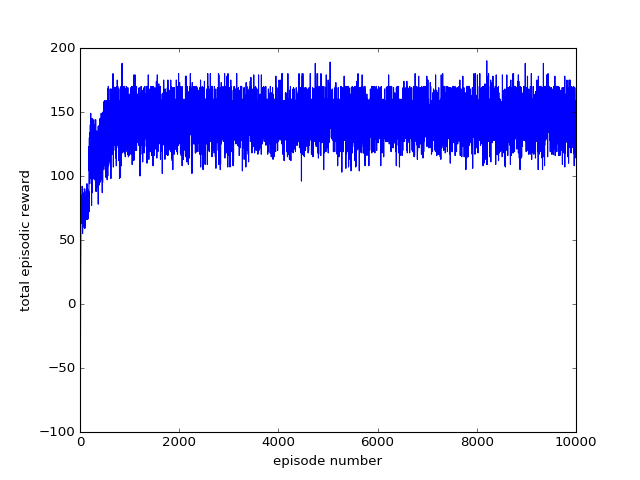

reward model
[[  0.  10.   0.   5.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]
Q function for up action
[[ 17.43201912  21.42668507  13.1379393   16.92846263  13.63647202]
 [ 16.76503515  18.88258522  14.32639598  15.03250007  12.88444671]
 [ 14.98517941  16.95350979  14.34848802  12.99408694  11.80725304]
 [ 13.35377864  14.67106123  13.06100534  11.26626437  10.50909939]
 [ 12.25840782  12.73461387  11.46738396  10.52826977   7.94305157]]
Q function for down action
[[ 16.04644056  21.38688481  15.33872489  16.95790507  12.51741981]
 [ 14.56142718  15.21567573  14.00306063  12.09026991  10.89220326]
 [ 12.4917165   13.29817691  12.20065495  10.75015215   9.79677041]
 [ 11.17111558  11.61244131  10.68825373   9.52478865   7.19694731]
 [ 11.04544187  11.6506445   10.63708194   9.54714756   6.36430936]]
Q function for left action
[[ 17.49458714  21.45306168  16.0335099   17.02070271  15.27082859]
 [ 15.61742146  1

<IPython.core.display.Javascript object>


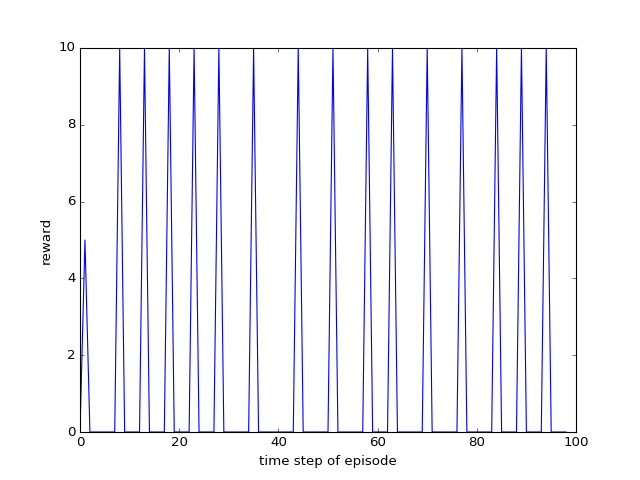

<IPython.core.display.Javascript object>


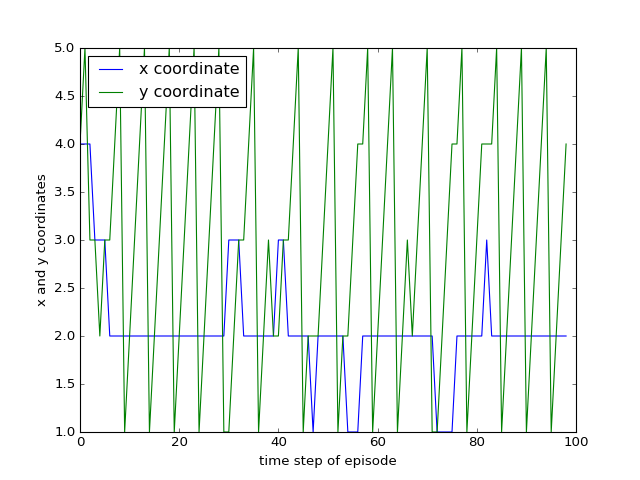

Exploit policy of agent, where: 1 is up, 2 is down, 3 is left and 4 is right
[[4 3 3 4 3]
 [4 1 3 1 3]
 [1 1 3 3 3]
 [1 1 1 3 1]
 [1 1 1 1 3]]


In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pylab
import gym
import sys
from gym import error, spaces, utils
from gym.utils import seeding
import matplotlib.ticker as plticker

class gridworld(gym.Env):
  metadata = {'render.modes': ['human']}

  def __init__(self): 
    self.render_label = 'f'
    self.gridnum = int(7) #size of gridworld
    self.location_x = np.random.randint(int(1),self.gridnum-1)
    self.location_y = np.random.randint(int(1),self.gridnum-1)
    self.action = int(0) # no initial action until computed
    self.previous_action = self.action
    self.previous_x = self.location_x
    self.previous_y = self.location_y
    self.previous_previous_x = self.previous_x
    self.previous_previous_y = self.previous_y
    self.allowed_actions = np.array([1,2,3,4])[np.newaxis]
    self.actionSet = np.matrix([1,2,3,4])
    self.episode_length = int(100)
    self.num_episodes = int(10000) # currently only running one episode, 10000
    self.my_alpha = 0.1
    self.my_gamma = 0.9
    self.my_epsilon = 0.1
    self.my_reward =np.array([ [-1,-1,-1,-1,-1,-1,-1],[-1, 0, 10, 0, 5, 0, -1],[-1, 0, 0, 0, 0, 0, -1],\
    [-1, 0, 0, 0, 0, 0, -1],[-1, 0, 0, 0, 0, 0, -1],[-1, 0, 0, 0, 0, 0, -1],[-1, -1, -1, -1, -1, -1, -1] ]) 
    self.my_reward = np.flipud(self.my_reward)
    self.my_reward_model = np.zeros([self.gridnum,self.gridnum])#reward model updated based on observations
    self.my_q_function = np.random.rand(self.gridnum,self.gridnum, int(4))# randomly initialized via reward model
    self.my_q_function[0::6,:,:] = 0# to prevent biasing agent with favorable "out of bound" q functions
    self.my_q_function[:,0::6,:] = 0# to prevent biasing agent with favorable "out of bound" q functions
    self.my_reward_log = np.random.rand(1, self.episode_length*self.num_episodes) # used to store reward for each time step
    self.my_episodic_cumulative_reward_log = np.random.rand(1,self.num_episodes)
    self.update_q_label = 0
    self.color_array = ['blue','orange']
    self.episode_counter = 0
    self.my_exploit_action_log = np.random.rand(self.gridnum,self.gridnum)
    self.my_state_log = np.random.rand(2, self.episode_length*self.num_episodes)
    pass
  def my_policy(self):
    if self.update_q_label > 1:
        self.previous_action = self.action # still want this because the agent selected a poor action and should evaluate it
    self.action = self.allowed_actions[0,\
    np.argmax(self.my_q_function[self.location_x,self.location_y,self.allowed_actions-1])]
    self.my_exploit_action_log[self.location_y,self.location_x] = int(self.action)
    if np.random.rand() <= self.my_epsilon:
        self.action = self.allowed_actions[0,np.random.randint(0,self.allowed_actions.shape[1])]
    return self.location_y,self.location_x,self.action
  def render(self,fig,ax,time_index): #mode='human', close=False <- no idea what this is for
    ax = fig.gca()    
    ax.clear()
    ax.grid(which='major', axis='both', linestyle='-')
    circle2 = plt.Circle((world.location_x+0.5, world.location_y+0.5), 0.5, color=self.color_array[np.mod(self.episode_counter,2)])#rand initialization
    ax.add_artist(circle2)
    fig.canvas.draw()
    pass
  def render_init(self):
    fig, (ax)=plt.subplots()
    intervals = float(1/world.gridnum)# dimension of grid affects size
    loc = plticker.MultipleLocator(base=intervals)
    ax.xaxis.set_major_locator(loc)
    ax.set_xlim(0, world.gridnum)
    ax.yaxis.set_major_locator(loc)
    ax.set_ylim(0, world.gridnum)
    return fig, ax
  def reset(self):
    self.location_x = np.random.randint(int(1),self.gridnum-1)
    self.location_y = np.random.randint(int(1),self.gridnum-1)
    self.previous_x = self.location_x
    self.previous_y = self.location_y
    self.previous_previous_x = self.previous_x
    self.previous_previous_y = self.previous_y
    self.update_q_label = 0
    self.episode_counter += 1
    pass
  def step(self):
    self.previous_previous_x = self.previous_x
    self.previous_previous_y = self.previous_y
    self.previous_x = self.location_x# only accurate for second step in episode
    self.previous_y = self.location_y# only accurate for second step in episode
    desired_action = self.action
    if np.random.rand() <= 0.1: # this part of the method is to enforce a 10% chance of a random transition
        self.action = self.allowed_actions[0,np.random.randint(1,self.allowed_actions.shape[1])]
    if self.my_reward[self.location_y,self.location_x] > 0:
        self.location_x = 3+1
        self.location_y = 2+1
        if self.my_reward[self.previous_y,self.previous_x] > 5:
            self.location_x = 1+1
            self.location_y = 0+1
    elif self.action == 1: # this part of the method is to select the desired deterministic action
        self.location_y += 1
    elif self.action == 2:
        self.location_y += -1
    elif self.action == 3:
        self.location_x += -1
    elif self.action == 4:
        self.location_x += 1
    self.action = desired_action# reports selected action, but has the agent move according to transition probability
    pass #return [(self.location_x, self.location_y)]
  def update_reward_model(self):# reversed y and x for reward (not model) to accommodate human-readable reward
    self.my_reward_model[self.location_y,self.location_x] = self.my_reward[self.location_y,self.location_x]
    pass
  def update_my_q_function(self):#,action,location_x,location_y):
    if self.update_q_label > 1:# update_q_label ensures that we do not update the q function when location is reset
        self.my_q_function[self.previous_previous_x,self.previous_previous_y,self.previous_action-1] +=\
        self.my_alpha*(self.my_reward_model[self.previous_previous_y,self.previous_previous_x]+\
        self.my_gamma*np.amax(self.my_q_function[self.previous_x,self.previous_y,:])-\
        self.my_q_function[self.previous_previous_x,self.previous_previous_y,self.previous_action-1])
    pass
world = gridworld()
if world.render_label == 't':
    fig, (ax) = world.render_init()
k=0 # counter for episodic cumulative reward
for i in range(1,world.episode_length * world.num_episodes - 1):
    world.update_reward_model()
    world.my_reward_log[0,i] = world.my_reward[world.location_y,world.location_x]
    world.my_state_log[:,i] = np.array([world.location_x,world.location_y])[np.newaxis]
    world.update_my_q_function()#update is for previous state, so put before state reversion
    world.update_q_label += 1# default is to update the q function after the first iteration
    if world.my_reward[world.location_y,world.location_x] < 0:
        world.location_x = world.previous_x
        world.location_y = world.previous_y
    world.my_policy() # closest to pragmatic results here
    world.step()# current state is now state AFTER action has been taken
    if np.mod(i+1,world.episode_length) == 0:
        world.my_episodic_cumulative_reward_log[0,k] = \
        np.sum(world.my_reward_log[0,(k*world.episode_length):(i+1)])# sums from k*episode_length to i
        k += 1
        world.reset()
    progress_checker = np.floor(0.1*world.episode_length*world.num_episodes)
    if np.mod(i+1,progress_checker) == 0:
        sys.stdout.write("\r"+"%s" % int(10+np.floor(i/progress_checker)*10) + '%')#updates progress without excessive output
    if world.render_label == 't':
        world.render(fig,ax,i)
sys.stdout.write("\r"+'done' + '\n')#displays complete progress and prints results on new lines
fig1, (ax1)=plt.subplots()
ax1.plot(world.my_episodic_cumulative_reward_log[0,0:-1])
plt.xlabel('episode number')
plt.ylabel('total episodic reward')
print('reward model' + '\n' + str(np.flipud(world.my_reward_model[1:6,1:6])))
print('Q function for up action' + '\n' + str(np.flipud(np.transpose(world.my_q_function[1:6,1:6,0]))))
print('Q function for down action' + '\n' + str(np.flipud(np.transpose(world.my_q_function[1:6,1:6,1]))))
print('Q function for left action' + '\n' + str(np.flipud(np.transpose(world.my_q_function[1:6,1:6,2]))))
print('Q function for right action' + '\n' + str(np.flipud(np.transpose(world.my_q_function[1:6,1:6,3]))))
print('total reward = ' + str(np.sum(world.my_reward_log[0,-world.episode_length:-1])))
fig2, (ax2) = plt.subplots()
ax2.plot(world.my_reward_log[0,-world.episode_length:-1])
plt.xlabel('time step of episode')
plt.ylabel('reward')
fig3, (ax3) = plt.subplots()
ax3.plot(np.transpose(world.my_state_log[0,-world.episode_length:-1]), label='x coordinate')
ax3.plot(np.transpose(world.my_state_log[1,-world.episode_length:-1]), label='y coordinate')
plt.xlabel('time step of episode')
plt.ylabel('x and y coordinates')
pylab.legend(loc='upper left')
print('Exploit policy of agent, where: 1 is up, 2 is down, 3 is left and 4 is right')
print(np.flipud(world.my_exploit_action_log[1:6,1:6]).astype(int))